In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.noise import *

In [2]:
nbins = 100

In [3]:
# CCAT-prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

[]

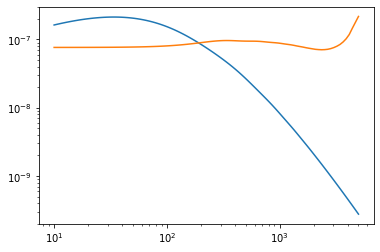

In [4]:
# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)

    
plt.plot(ells, ClKK)
plt.plot(ells, f_N0(ells))
plt.loglog()

In [5]:
# if no high pass IKappa
from  LIMxCMBL.kernels import *
f_KLIM   = get_f_KI()
f_Kkappa = get_f_Kkappa()

f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)

In [6]:
deltas.shape

(128,)

In [7]:
chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), nbins + 1)
chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
dchi_binned = np.mean(np.diff(chi_bin_edges))

In [8]:
Ik_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_zmin_%.5f_zmax_%.5f_quad_nbins_%d.npy'%(zmin, zmax, nbins)
I_kappa = np.load(Ik_fname)

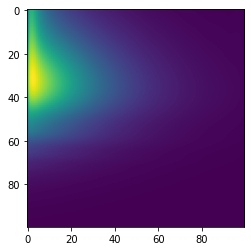

In [9]:
plt.imshow(I_kappa)

In [10]:
external_chis   = chi_bin_centers

In [11]:
from scipy.integrate import simpson, trapezoid

In [12]:
SNR2_per_mode_diag = {}
SNR2_per_mode = {}

In [13]:
from scipy.integrate import quad_vec

In [14]:
# if no high pass IKappa
from  LIMxCMBL.kernels import *
f_KLIM   = get_f_KI()
f_Kkappa = get_f_Kkappa()

f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)

_deltas = deltas.reshape(1, -1)

def f_Ik(chi):
    _minus = chi * (1 - _deltas)
    _plus  = chi * (1 + _deltas)

    f_Kpsi = f_KLIM_windowed
    f_Kphi = f_Kkappa

    prefactor = 2 / chi
    kernels = (f_Kpsi(_minus) * f_Kphi(_plus) + f_Kpsi(_plus) * f_Kphi(_minus))
    inner_integral_resampled = f_inner_integral(chi)
    integrand = prefactor*kernels*inner_integral_resampled*deltas_reshaped
    return trapezoid(y=integrand, x=np.log(deltas), axis = -1)

integrand =  lambda chi: (f_Ik(chi)**2 / (1/chi**2))[0]
no_filter_SNR2, _ = quad_vec(integrand, chimin, chimax, epsabs = 0.0, epsrel = 1e-3)
no_filter_SNR2 /= (ClKK + f_N0(ells))

SNR2_per_mode_diag[0.0] = no_filter_SNR2
SNR2_per_mode[0.0] = SNR2_per_mode_diag[0.0]

In [15]:
Lambda_idx = -1
for Lambda in tqdm(Lambdas):
    Lambda_idx += 1
    
    eHIeHI_oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_%.5f_zmax_%.5f_Lambda_idx_%.d_from_quad_nbins_%d.npy'%(zmin, zmax, Lambda_idx, nbins)
    eHIeHI_binned = np.load(eHIeHI_oup_fname)
    

    ILo_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/ILok_zmin_%.5f_zmax_%.5f_idx_%d_quad_nbins_%d.npy'%(zmin, zmax, Lambda_idx, nbins)
    ILo_kappa = np.load(ILo_kappa_fname)
    IHi_kappa = I_kappa - ILo_kappa
    
    L = np.linalg.cholesky(eHIeHI_binned)
    y = np.linalg.solve(L, IHi_kappa.T)
    x = np.linalg.solve(L.T, y)
    SNR2_per_mode[Lambda] = np.einsum('ij,ji->i', IHi_kappa, x) / (ClKK + f_N0(ells))

    L = np.linalg.cholesky(np.diag(np.diag(eHIeHI_binned)))
    y = np.linalg.solve(L, IHi_kappa.T)
    x = np.linalg.solve(L.T, y)
    SNR2_per_mode_diag[Lambda] = np.einsum('ij,ji->i', IHi_kappa, x) / (ClKK + f_N0(ells))


100%|██████████| 25/25 [00:00<00:00, 213.34it/s]


In [16]:
SNR2_per_mode_full = {}
SNR2_per_mode_full[0.0] = SNR2_per_mode_diag[0.0]

Lambda_idx = -1
for Lambda in tqdm(Lambdas):
    Lambda_idx += 1
    try:
        computed_oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/snr_per_mode_scipy_zmin_%.5f_zmax_%.5f_Lambda_idx_%d_log2_%d'%(zmin, zmax, Lambda_idx, 13)
        oup1_fname = computed_oup_fname + '_full.npy'
        SNR2_per_mode_full[Lambda]   = np.load(oup1_fname)
    except:
        print('skipping', Lambda_idx, Lambda)

100%|██████████| 25/25 [00:00<00:00, 2453.21it/s]

skipping 16 0.004641588833612777
skipping 17 0.006812920690579608
skipping 18 0.01
skipping 19 0.01467799267622069
skipping 20 0.021544346900318822
skipping 21 0.03162277660168379
skipping 22 0.046415888336127774
skipping 23 0.06812920690579609
skipping 24 0.1


In [19]:
Lambdas = np.array(sorted(list(SNR2_per_mode.keys())))

In [20]:
rainbow_colors = plt.cm.rainbow(np.linspace(0, 1, len(SNR2_per_mode_diag)))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=rainbow_colors[::-1])

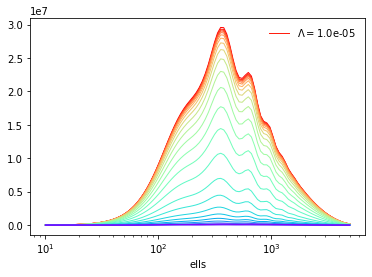

In [21]:
plt.figure(facecolor = 'w')
for Lambda in Lambdas:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_diag[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

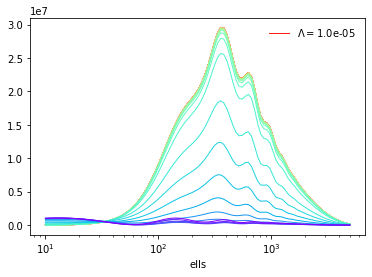

In [22]:
plt.figure(facecolor = 'w')
for Lambda in Lambdas:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

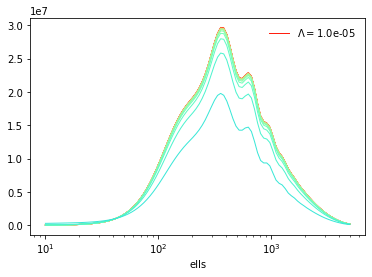

In [23]:
plt.figure(facecolor = 'w')
for Lambda in SNR2_per_mode_full:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_full[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

In [24]:
plt.show()
plt.rcParams['text.usetex'] = True

In [26]:
SNR2_per_Omega_per_invPei_full = np.zeros(len(SNR2_per_mode_full), dtype = np.float64)
for Lambda_idx in range(len(SNR2_per_mode_full)):
    Lambda = Lambdas[Lambda_idx]    
    SNR2_per_Omega_per_invPei_full[Lambda_idx] = trapezoid(x = np.log(ells), 
                                           y = SNR2_per_mode_full[Lambda] * ells ** 2 / 2 / np.pi)

In [28]:
SNR2_per_Omega_per_invPei_diag = np.zeros(len(SNR2_per_mode_diag))
SNR2_per_Omega_per_invPei = np.zeros(len(SNR2_per_mode))

for Lambda_idx,Lambda in enumerate(Lambdas):
    SNR2_per_Omega_per_invPei_diag[Lambda_idx] = trapezoid(x = np.log(ells), 
                                                           y = SNR2_per_mode_diag[Lambda] * ells ** 2 / 2 / np.pi)
    SNR2_per_Omega_per_invPei[Lambda_idx] = trapezoid(x = np.log(ells), 
                                                           y = SNR2_per_mode[Lambda] * ells ** 2 / 2 / np.pi)

Text(0, 0.5, '$${\\sf SNR}^2 \\times \\frac 1 {{\\Omega}\\ [\\sf rad^2]}\\times {P^{\\epsilon_I}}\\left[\\sf Mpc^{3}\\frac{\\sf kJy^2}{\\sf sr^2} \\right]$$')

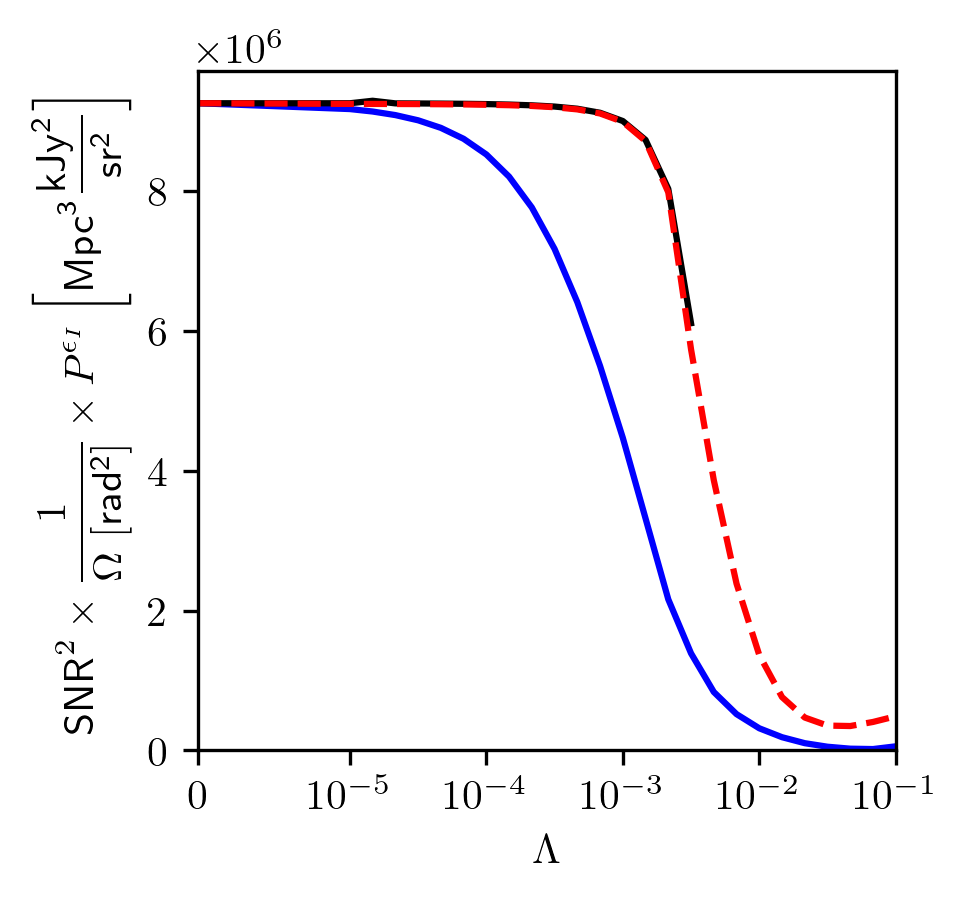

In [30]:
plt.figure(figsize = (3,3) ,dpi = 300, facecolor = 'w')

plt.plot(SNR2_per_mode_diag.keys(), (SNR2_per_Omega_per_invPei_diag), c='b')
plt.plot(SNR2_per_mode_full.keys(), (SNR2_per_Omega_per_invPei_full), 'k')
plt.plot(Lambdas, (SNR2_per_Omega_per_invPei), 'r--')

plt.xscale('symlog', linthresh = 1e-5)
plt.xlim(0, 1e-1)
plt.ylim(0, np.max(SNR2_per_Omega_per_invPei) * 1.05)

plt.xlabel(r'$\Lambda$')
plt.ylabel(r'$${\sf SNR}^2 \times \frac 1 {{\Omega}\ [\sf rad^2]}\times {P^{\epsilon_I}}\left[\sf Mpc^{3}\frac{\sf kJy^2}{\sf sr^2} \right]$$')

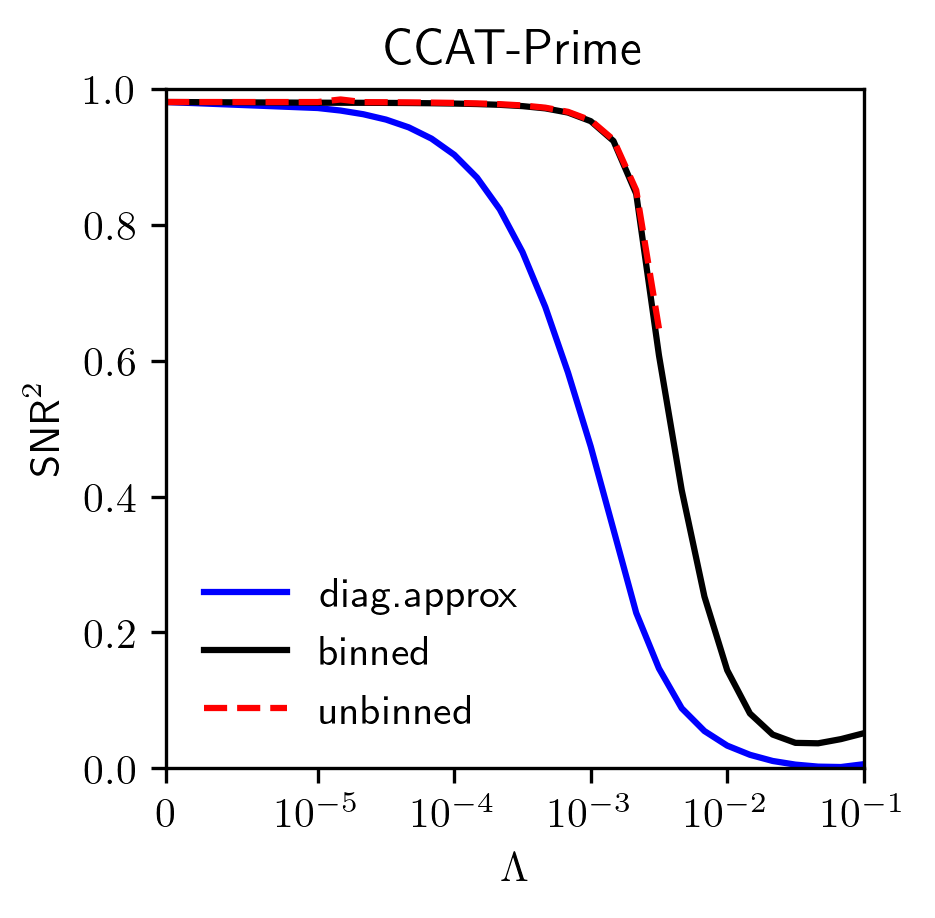

In [34]:
plt.figure(figsize = (3,3) ,dpi = 300, facecolor = 'w')


plt.plot(SNR2_per_mode_diag.keys(), (SNR2_per_Omega_per_invPei_diag * Omega_field / Pei), 
         c='b',
        label='diag.approx')



plt.plot(Lambdas, (SNR2_per_Omega_per_invPei * Omega_field / Pei), 
         'k',
        label='binned')

plt.plot(SNR2_per_mode_full.keys(), (SNR2_per_Omega_per_invPei_full * Omega_field / Pei), 
         'r--',
        label='unbinned')

plt.xscale('symlog', linthresh = 1e-5)
fundamental = 2*np.pi/(chimax - chimin)
plt.xlim(0, 1e-1)
plt.ylim(0, 1)
plt.xlabel(r'$\Lambda$')
plt.ylabel(r'$${\sf SNR}^2$$')
plt.title('CCAT-Prime')

plt.legend(frameon=False)

In [ ]:
np.logspace(-5, -1, 25)

In [ ]:
np.logspace(-5, 0, 31)